<a href="https://colab.research.google.com/github/katL7/GTSRB-APS360/blob/CNN-from-scratch-is-working/APS360_Traffic_Sign_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import drive
import os
import matplotlib.pyplot as plt

## Mount Google drive

In [67]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Dataset

In [19]:
# split into training, validation and test - stratify each
def get_val_test(batch_size=64, img_size=50):
    # Rescale images to all be the same size
    data_transform = transforms.Compose([transforms.Resize((img_size,img_size)), 
                                         transforms.ToTensor()])

    # Get paths to data in folder
    data = datasets.GTSRB('data', download=True, split='test',
                           transform=data_transform)

    class_idxs = {}
    #Loop through filenames and sort into classes
    for i, data in enumerate(data):
        img, label = data
        if label in class_idxs:
          class_idxs[label].append(i)
        else:
          class_idxs[label] = [i]

    np.random.seed(1000)
    test_indices = []
    val_indices = []

    for class_key in class_idxs:
      #Split validation/testing indices as 0.7/0.3 split by class
      np.random.shuffle(class_idxs[class_key])
      split = int(len(class_idxs[class_key]) * 0.7)
      val_indices += class_idxs[class_key][:split]
      test_indices += class_idxs[class_key][split:]

    #Shuffle the testing/validation indices
    np.random.shuffle(test_indices)
    np.random.shuffle(val_indices)

    #testing data loader
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
          num_workers=0, sampler=test_sampler)

    #Validation data loader
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
          num_workers=0, sampler=val_sampler)
    
    return val_loader, test_loader

In [6]:
def get_train_data_loader(batch_size=64, img_size=50):
    # Rescale images to all be the same size
    data_transform = transforms.Compose([transforms.Resize((img_size,img_size)), 
                                         transforms.ToTensor()])

    # Get paths to data in folder
    data = datasets.GTSRB('data', download=True, split="train",
                          transform=data_transform)
  
    np.random.seed(1000)
    #test data loader
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
          num_workers=0, shuffle=True)
    
    return train_loader



In [20]:
val_loader, test_loader = get_val_test(64)

In [21]:

train_loader = get_train_data_loader(64)

# Setting up the model using transfer learning

First I'm gonna try my own CNN since AlexNet was trained on 224x224 and our images are a lot smaller (not sure if this matters)

In [71]:
class TrafficSignModel(nn.Module):
  def __init__(self):
     super(TrafficSignModel, self).__init__()
     self.name = "TrafficSignModel"
     self.conv1 = nn.Conv2d(3, 5, 5) # 3 input channels, 5 output channels, kernel size of 5
     self.pool = nn.MaxPool2d(2, 2) # kernel size of 2, stride of 2
     self.conv2 = nn.Conv2d(5, 10, 5) # 5 input channels, 10 output channels, kernel size of 5
     self.fc1 = nn.Linear(10 * 9 * 9, 28) # 10 input channels, 12*12 input dimension, output to 28 channels
     self.fc2 = nn.Linear(28, 43) # 28 channels to 43 channels for classification
         
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 10 * 9 * 9) # Flatten image
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

Train the network

In [9]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [10]:
# Function to obtain accuracy
def get_accuracy(net, data_loader):
  correct = 0
  total = 0

  for imgs, labels in data_loader:
    output = net(imgs)
    prediction = output.max(1, keepdim=True)[1]
    correct += prediction.eq(labels.view_as(prediction)).sum().item()
    total += imgs.shape[0]
  return correct / total

In [11]:
# Function to obtain error
def get_error(net, data_loader):
  correct = 0
  total = 0
  evaluate_net = net.eval()

  for imgs, labels in data_loader:
    output = evaluate_net(imgs)
    prediction = output.max(1, keepdim=True)[1]
    correct += prediction.eq(labels.view_as(prediction)).sum().item()
    total += imgs.shape[0]
  return (total - correct) / total

In [12]:
# Function to obtain loss
def get_loss(net, data_loader, criterion):
  loss = 0.0
  total_loss = 0.0
  evaluate_net = net.eval()
  for imgs, labels in data_loader:
    output = evaluate_net(imgs)
    loss = criterion(output, labels)
    total_loss += loss.item()

  loss = float(total_loss) / (len(data_loader))
  return loss

In [13]:
# Function to get model name
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [75]:
# Function to plot Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [69]:
def train_net(net, train_loader, val_loader, batch_size=64, learning_rate=0.01, num_epochs=30):
  # Set the seed for reproducible results
  torch.manual_seed(1000)

  # Define the loss function - we will use Cross Entropy Loss for this classification problem
  criterion = nn.CrossEntropyLoss()

  # Define the optimizer -  we will use Adaptive moment estimation
  optimizer = optim.Adam(net.parameters(), lr = learning_rate)

  # Arrays to store stats
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  n = 0 # number iterations
  for epoch in range(num_epochs):
    total_train_loss = 0.0
    for imgs, labels in train_loader:
     # print(imgs)
     # print(type(imgs))
      out = net(imgs)                 # forward passs
      loss = criterion(out, labels)   # compute loss
      loss.backward()                 # backward pass
      optimizer.step()                # update paramters
      optimizer.zero_grad()           # clean up

      total_train_loss += loss.item()

    train_err[epoch] = get_error(net, train_loader)
    train_loss[epoch] = float(total_train_loss) / (len(train_loader))
    val_err[epoch] = get_error(net, val_loader)
    val_loss[epoch] = get_loss(net, val_loader, criterion)

    print(("Epoch {}: Train error: {}, Train loss: {}, Val error: {}, Val loss: {}").format(
        epoch +1,
        train_err[epoch],
        train_loss[epoch],
        val_err[epoch],
        val_loss[epoch]))
    
    # Save the current model after each epoch
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    torch.save(net.state_dict(), model_path)

  # Finished training, save statistics to CSV
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), val_err)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

  # plotting
  plot_training_curve(model_path)


Try to overfit the data

In [50]:
def get_debug_loader():
  # Rescale images to all be the same size

  data_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((50,50))])
    
  # Get paths to data in folder
  debug_data = datasets.GTSRB('data', download=True, split="train",
                        transform=data_transform)
  #print(type(debug_data))
  #debug_data = list(debug_data)
  #debug_data = debug_data[:64]
  #print(type(debug_data))

  np.random.seed(1000)
  indices = np.arange(len(debug_data))
  np.random.shuffle(indices)
  debug_sampler = SubsetRandomSampler(indices[:64])

  debug_loader = torch.utils.data.DataLoader(debug_data, batch_size=64,
        num_workers=0, sampler=debug_sampler)
  return debug_loader


Epoch 1: Train error: 0.953125, Train loss: 3.7591512203216553, Val error: 0.953125, Val loss: 3.708005428314209
Epoch 2: Train error: 0.953125, Train loss: 3.708005428314209, Val error: 0.953125, Val loss: 3.6142754554748535
Epoch 3: Train error: 0.9375, Train loss: 3.6142752170562744, Val error: 0.9375, Val loss: 3.5585944652557373
Epoch 4: Train error: 0.921875, Train loss: 3.5585947036743164, Val error: 0.921875, Val loss: 3.467223644256592
Epoch 5: Train error: 0.875, Train loss: 3.46722412109375, Val error: 0.875, Val loss: 3.4252514839172363
Epoch 6: Train error: 0.875, Train loss: 3.4252512454986572, Val error: 0.875, Val loss: 3.3151462078094482
Epoch 7: Train error: 0.875, Train loss: 3.3151464462280273, Val error: 0.875, Val loss: 3.2621352672576904
Epoch 8: Train error: 0.890625, Train loss: 3.2621352672576904, Val error: 0.890625, Val loss: 3.190049886703491
Epoch 9: Train error: 0.859375, Train loss: 3.190049886703491, Val error: 0.859375, Val loss: 3.093668222427368
Epoc

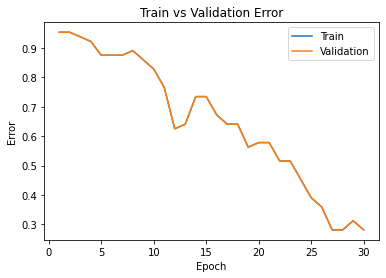

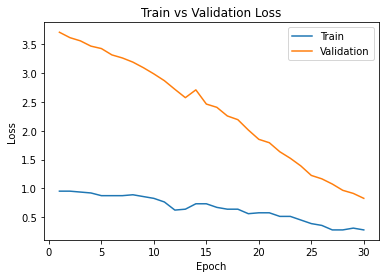

In [77]:
overfit_loader = get_debug_loader()
model = TrafficSignModel()
train_net(model, overfit_loader, overfit_loader, batch_size=64, learning_rate=0.01, num_epochs=30)

In [79]:
model = TrafficSignModel()
train_net(model, train_loader, train_loader, batch_size=64, learning_rate=0.01, num_epochs=30)

Epoch 1: Train error: 0.9436936936936937, Train loss: 3.515002762956871, Val error: 0.9436936936936937, Val loss: 3.5121813878166876


KeyboardInterrupt: ignored

## Jordan just playing around to try to get a dataloader object
I'm using Lab 2 as a guide

Figuring out the structure of the dataset

In [ ]:
print(type(gtsrb_data))
print(gtsrb_data)
print(len(gtsrb_data))
print(gtsrb_data[10000][1])

<class 'torchvision.datasets.gtsrb.GTSRB'>
Dataset GTSRB
    Number of datapoints: 26640
    Root location: data
26640
10


Using some helper functions that I've slightly modified from Lab 2

In [ ]:
def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        # label_class = classes[label_index] # ex: 'cat'
        if label_index in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of signs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of ints denoting the index of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of ints denoting the index of each class
    """

    classes = tuple(range(0,43))
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load GTSRB training data
    trainset = torchvision.datasets.GTSRB(root='./data', split='train', transform=transform, download=True)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load GTSRB testing data
    testset = torchvision.datasets.GTSRB(root='./data', split='test', transform=transform, download=True)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

In [ ]:
classes = tuple(range(0,43))
target_classes = (0,)
print(type(classes[0]))
print(classes)
indices_class_0 = get_relevant_indices(gtsrb_data, classes, target_classes)
print(indices_class_0) # Now I have the indices in gtsrb_data of ClassId=0

# Get data loaders for training, validation, and test sets (images are only of ClassId=0)
train_loader, val_loader, test_loader, classes = get_data_loader(target_classes, batch_size=5)

<class 'int'>
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]


  0%|          | 0/88978620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


  0%|          | 0/99620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [ ]:
# Playing around with data loaders I created above
print(len(train_loader)) # There are 24 batches (5 images/batch) in the train loader -> This is 120 images which is 80% of 150!
print(len(val_loader)) # There are 6 batches (5 images/batch) in the val loader -> This is 30 images which is 20% of 150
print(len(test_loader)) # There are 12 batches (5 images/batch) in the test loader -> This is 60 images

24
6
12


Next I'll try to plot some of the images, just to see what we're working with

I don't think this is working because the images are of different sizes, we'll have to figure out what we're doing about this.

In [ ]:
k = 0
for images, labels in enumerate(train_loader):
    # since batch_size = 5, there are 5 images in 'images'
    for i in range(0,5):
      image = images[i]
      # place the colour channel at the end, instead of at the beginning
      img = np.transpose(image, [1,2,0])
      # normalize pixel intensity values to [0, 1]
      img = img / 2 + 0.5
      plt.subplot(3, 5, k+1)
      plt.axis('off')
      plt.imshow(img)

    k += 1
    if k > 14:
        break

RuntimeError: ignored

**Helper Functions**

Will need functions to


*   Get model name (for training)
*   Evaluate network on validation set
*   Plot the training curves




**Define Model Architecture**

In [ ]:
class TrafficSignModel(nn.Module):
  def __init__(self):
     super(TrafficSignModel, self).__init__()
     self.name = "TrafficSignModel"
     self.conv1 = nn.Conv2d(3, 5, 5) # 3 input channels, 5 output channels, kernel size of 5
     self.pool = nn.MaxPool2d(2, 2), # kernel size of 2, stride of 2
     self.conv2 = nn.Conv2d(5, 10, 5), # 5 input channels, 10 output channels, kernel size of 5
     self.fc1 = nn.Linear() # Will need to figure out these dimensions (based on input dimensions of image - how are we handling this?)
     self.fc2 = nn.Linear() # Will need to figure out these dimensions (based on how many different classes we are working with - do we know?)
         
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, ) # Will need to figure out these dimensions - see above
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

**Training**

Function to train the neural network
Need to decide loss function and optimizer

A lot of this code can be adopted from the Labs and tutorials

## Katherine trying to augment the data

In [ ]:
augmented_datasets = []

my_transform = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ToTensor(),
])

for _ in range(2):
    gtsrb_new = datasets.GTSRB('data', download=True, transform=my_transform)
    augmented_datasets.append(gtsrb_new)

concat = torch.utils.data.ConcatDataset(augmented_datasets)

In [ ]:
# mount our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('drive/MyDrive/APS360/Project/SyRa-Synthesized_Rain_dataset-main')

In [ ]:
os.listdir("assets/folder_of_your_data/folder_of_your_data/")

['img_2222_meditation_ashley_sharp_crop.256x256.jpg', 'outdoors.256x256.jpg']

In [ ]:
img.shape

torch.Size([64, 3, 256, 256])

In [ ]:
#train_data = get_train_data_loader(img_size=256)

for i, data in enumerate(train_data):
  img, label = data
  for j in range(img.shape[0]):
      torchvision.utils.save_image(img[j,:,:,:], 'assets/folder_of_your_data/folder_of_your_data/{}{}.png'.format(i,j))
  if i>=0:
    break

In [ ]:
!pip install munch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=344a5e2ab1a0b6c3a1c4521d57723b585f4f054938f3190d25b69ee2816b5ae0
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg


In [ ]:
import munch
import ffmpeg
import os

In [ ]:
os.chdir('drive/MyDrive/APS360/Project/SyRa-Synthesized_Rain_dataset-main')

In [ ]:
%%shell
python main.py --img_size 256 --mode syn --checkpoint_dir expr/checkpoint/SyRa --out_dir expr/result --data folder_of_your_data --resume_iter 100000

CUDA_number : 0
Namespace(batch_size=8, beta1=0.01, beta2=0.99, checkpoint_dir='expr/checkpoint/SyRa', data='folder_of_your_data', ds_iter=150000, eval_dir='expr/eval/SyRa', f_lr=1e-06, gpu=0, gt=1, hidden_dim=512, img_size=256, lambda_NPMI=0.1, lambda_SGD=0.1, lambda_cyc=1, lambda_ds=1, lambda_reg=1, lambda_sty=1, latent_dim=16, lm_path='expr/checkpoints/celeba_lm_mean.npz', lr=0.0001, mode='syn', num_domains=2, num_outs_per_domain=5, num_workers=4, out_dir='expr/result', print_every=10, rain_dir='assets', randcrop_prob=0.5, ref_dir='assets/representative/yose/ref', result_dir='expr/results', resume_iter=100000, sample_dir='expr/samples/SyRa', sample_every=10000, save_every=10000, seed=777, src_dir='assets/representative/yose/src', style_dim=64, total_iters=100000, train_img_dir='data/rains/train', val_batch_size=10, val_img_dir='data/rains/val', w_hpf=0, weight_decay=0.0001, wing_path='expr/checkpoints/wing.ckpt')
Number of parameters of generator: 33991564
Number of parameters of ma

CalledProcessError: ignored